In [3]:
import talib #this is a good library for TA
from talib.abstract import *
import pandas_datareader as web
import datetime as dt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import ParameterGrid
import sklearn
from sklearn import preprocessing
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel
#https://github.com/mrjbq7/ta-lib/blob/master/docs/funcs.md

In [4]:
#this gets all the historical data of the coin
def getData(id):
    end = dt.datetime.now()
    start = dt.datetime(2000,1,1)
    data = web.DataReader(id+"-USD", 'yahoo', start, end)
    data = data.rename(columns={"Open":"open","High":"high","Low":"low","Close":"close","Volume":"volume"})
    return data

In [5]:
data = getData('eth')
data

,high,low,open,close,volume,Adj Close
Date,,,,,,
2017-11-09,329.451996,307.056000,308.644989,320.884003,893249984,320.884003
2017-11-10,324.717987,294.541992,320.670990,299.252991,885985984,299.252991
2017-11-11,319.453003,298.191986,298.585999,314.681000,842300992,314.681000
2017-11-12,319.153015,298.513000,314.690002,307.907990,1613479936,307.907990
2017-11-13,328.415009,307.024994,307.024994,316.716003,1041889984,316.716003
...,...,...,...,...,...,...
2022-02-06,3061.261230,2965.429932,3014.959717,3057.476074,9466018022,3057.476074
2022-02-07,3182.528320,3002.927002,3057.422119,3142.470703,15197063785,3142.470703
2022-02-08,3219.472656,3038.377930,3143.008545,3122.608643,17136080906,3122.608643


In [7]:
#different TA 
ema_smallW = EMA(data, timeperiod=5)
ema_bigW = EMA(data,timeperiod=14)
ema_ratio = (ema_smallW/ema_bigW)

rsi = RSI(data,timeperiod=2)

upperband, middleband, lowerband = BBANDS(data["close"], timeperiod=5, nbdevup=2.0, nbdevdn=2.0, matype=0)
upperband = upperband/data["close"]
middleband = middleband/data["close"]
lowerband = lowerband/data["close"]

real = ADOSC(data, fastperiod=3, slowperiod=10)
real = real.apply(lambda x: 1 if x > 0 else -1)

returns = data["close"].pct_change(periods=7)
returns= returns.shift(-7)
returns = returns.apply(lambda x: 'long' if x > 0 else 'short')

features = {"ema_ratio":ema_ratio,"rsi":rsi,"uband":upperband,"mband":middleband,"lband":lowerband,"volumeOsc":real,"return":returns}
features = pd.DataFrame(features)
features = features.dropna()
features.sample(n=20)

,ema_ratio,rsi,uband,mband,lband,volumeOsc,return
Date,,,,,,,
2020-06-20,0.989041,43.988253,1.031344,1.008363,0.985381,1,short
2018-03-21,0.899561,61.372283,1.013351,0.985187,0.957023,1,short
2020-03-24,0.932127,79.349678,1.028280,0.954948,0.881616,1,short
2020-04-28,1.057616,96.899533,1.018642,0.985518,0.952394,1,long
2018-07-09,1.009010,27.053155,1.041398,1.009430,0.977461,1,long
2020-07-24,1.055218,98.929546,1.048285,0.929222,0.810159,1,long
2020-12-05,1.038317,57.950457,1.046870,0.995091,0.943313,1,short
2017-12-07,1.014495,26.526416,1.121502,1.041571,0.961641,-1,long
2021-06-21,0.920033,8.358265,1.326234,1.156193,0.986152,-1,long


In [8]:
#spliting data for testing
labels = np.array(features['return'])
features= features.drop('return', axis = 1)
feature_list = list(features.columns)
features = np.array(features)
train_size = int(0.8 * labels.shape[0])
train_features, test_features = features[:train_size], features[train_size:]
train_labels, test_labels = labels[:train_size], labels[train_size:]

In [9]:
#run first model, and the given accuarcy was 50.8%
rfc = RandomForestClassifier(n_estimators = 200,random_state = 42)
rfc.fit(train_features, train_labels)
predictions = rfc.predict(test_features)
metrics.accuracy_score(predictions, test_labels)

0.5080906148867314

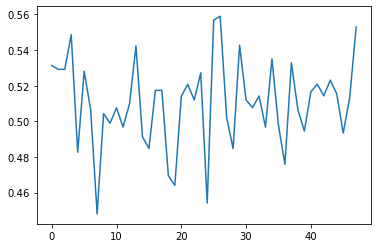

In [505]:
#this is to optimize RSI
acc = []

for j in range(2,50):
    returns = data["close"].pct_change(periods=7)
    returns= returns.shift(-7)
    returns = returns.apply(lambda x: 'long' if x > 0 else 'short')
    feature = RSI(data,timeperiod=j)
    features = {"return":returns,"feature":feature}
    features = pd.DataFrame(features)
    features = features.dropna()
    labels = np.array(features['return'])
    features= features.drop('return', axis = 1)
    feature_list = list(features.columns)
    features = np.array(features)
    train_size = int(0.8 * labels.shape[0])
    train_features, test_features = features[:train_size], features[train_size:]
    train_labels, test_labels = labels[:train_size], labels[train_size:]
    rfc = RandomForestClassifier(bootstrap= False,n_estimators = 200,random_state = 42)
    rfc.fit(train_features, train_labels)
    predictions = rfc.predict(test_features)
    acc.append((metrics.accuracy_score(predictions, test_labels),j))
rsiOp = pd.DataFrame(acc, columns = ["acc","window"])
plt.plot(rsiOp["acc"])
#choose RSI window 5

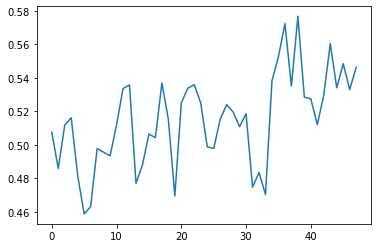

In [9]:
#this is to optimize the Boilliger bands
acc = []

for j in range(2,50):
    returns = data["close"].pct_change(periods=7)
    returns= returns.shift(-7)
    returns = returns.apply(lambda x: 'long' if x > 0 else 'short')
    upperband, middleband, lowerband = BBANDS(data["close"], timeperiod=j, nbdevup=2.0, nbdevdn=2.0, matype=0)
    upperband = upperband/data["close"]
    middleband = middleband/data["close"]
    lowerband = lowerband/data["close"]
    features = {"uband":upperband,"mband":middleband,"lband":lowerband,"return":returns}
    features = pd.DataFrame(features)
    features = features.dropna()
    labels = np.array(features['return'])
    features= features.drop('return', axis = 1)
    feature_list = list(features.columns)
    features = np.array(features)
    train_size = int(0.8 * labels.shape[0])
    train_features, test_features = features[:train_size], features[train_size:]
    train_labels, test_labels = labels[:train_size], labels[train_size:]
    rfc = RandomForestClassifier(bootstrap= False,n_estimators = 200)
    rfc.fit(train_features, train_labels)
    predictions = rfc.predict(test_features)
    acc.append((metrics.accuracy_score(predictions, test_labels),j))
bbandOp = pd.DataFrame(acc, columns = ["acc","window"])
plt.plot(bbandOp["acc"])
#choose window of 40

In [10]:
bbandOp

,acc,window
0,0.507559,2
1,0.485961,3
2,0.511879,4
3,0.516199,5
4,0.481641,6
5,0.458874,7
6,0.463203,8
7,0.497835,9
8,0.495671,10
9,0.493506,11


In [394]:
def emaRatio(data,smallWin,bigWin):
    ema_smallW = EMA(data, timeperiod=smallWin)
    ema_bigW = EMA(data,timeperiod=bigWin)
    ema_ratio = (ema_smallW/ema_bigW)
    return ema_ratio


In [435]:
#optimize ema ratio
acc = []
for i in range(2,20):
    for j in range(i+1,30,2):
        returns = data["close"].pct_change(periods=7)
        returns= returns.shift(-7)
        returns = returns.apply(lambda x: 'long' if x > 0 else 'short')
        feature = emaRatio(data,i,j)
        features = {"return":returns,"feature":feature}
        features = pd.DataFrame(features)
        features = features.dropna()
        labels = np.array(features['return'])
        features= features.drop('return', axis = 1)
        feature_list = list(features.columns)
        features = np.array(features)
        train_size = int(0.8 * labels.shape[0])
        train_features, test_features = features[:train_size], features[train_size:]
        train_labels, test_labels = labels[:train_size], labels[train_size:]
        rfc = RandomForestClassifier(bootstrap= False,n_estimators = 200)
        rfc.fit(train_features, train_labels)
        predictions = rfc.predict(test_features)
        acc.append((metrics.accuracy_score(predictions, test_labels),i,j))
emaRatioOp = pd.DataFrame(acc, columns = ["acc","short","long"])
emaRatioOp.sort_values(by=['acc'],ascending=False)[0:30]
#choose 7 and 18

,acc,short,long
69,0.556190,7,18
130,0.554493,13,26
24,0.553435,3,24
100,0.552381,10,19
136,0.551527,14,23
164,0.550669,18,27
72,0.549618,7,24
1,0.548387,2,5
70,0.547710,7,20
110,0.547710,11,20


In [21]:
#Trying to optimize the Chainkin Oscillator, but notice on how all the accuarcy is all the same
acc = []
for i in range(2,20):
    for j in range(i+1,30,2):
        returns = data["close"].pct_change(periods=7)
        returns= returns.shift(-7)
        returns = returns.apply(lambda x: 'long' if x > 0 else 'short')
        real = ADOSC(data, fastperiod=3, slowperiod=10)
        real = real.apply(lambda x: 1 if x > 0 else -1)
        features = {"return":returns,"feature":real}
        features = pd.DataFrame(features)
        features = features.dropna()
        labels = np.array(features['return'])
        features= features.drop('return', axis = 1)
        feature_list = list(features.columns)
        features = np.array(features)
        train_size = int(0.8 * labels.shape[0])
        train_features, test_features = features[:train_size], features[train_size:]
        train_labels, test_labels = labels[:train_size], labels[train_size:]
        rfc = RandomForestClassifier(bootstrap= False,n_estimators = 200)
        rfc.fit(train_features, train_labels)
        predictions = rfc.predict(test_features)
        acc.append((metrics.accuracy_score(predictions, test_labels),i,j))
adlOP = pd.DataFrame(acc, columns = ["acc","short","long"])
adlOP.sort_values(by=['acc'],ascending=False)[0:30]

,acc,short,long
0,0.605603,2,3
117,0.605603,12,17
109,0.605603,11,18
110,0.605603,11,20
111,0.605603,11,22
112,0.605603,11,24
113,0.605603,11,26
114,0.605603,11,28
115,0.605603,12,13
116,0.605603,12,15


In [18]:
#final model with accuarcy of 53.8%
ema_smallW = EMA(data, timeperiod=7)
ema_bigW = EMA(data,timeperiod=18)
ema_ratio = (ema_smallW/ema_bigW)

rsi = RSI(data,timeperiod=5)

upperband, middleband, lowerband = BBANDS(data["close"], timeperiod=40, nbdevup=2.0, nbdevdn=2.0, matype=0)
upperband = upperband/data["close"]
middleband = middleband/data["close"]
lowerband = lowerband/data["close"]

returns = data["close"].pct_change(periods=7)
returns= returns.shift(-7)
returns = returns.apply(lambda x: 'long' if x > 0 else 'short')

features = {"ema_ratio":ema_ratio,"rsi":rsi,"uband":upperband,"mband":middleband,"lband":lowerband,"return":returns}
features = pd.DataFrame(features)
features = features.dropna()
features.sample(n=20)

labels = np.array(features['return'])
features= features.drop('return', axis = 1)
feature_list = list(features.columns)
features = np.array(features)
train_size = int(0.8 * labels.shape[0])
train_features, test_features = features[:train_size], features[train_size:]
train_labels, test_labels = labels[:train_size], labels[train_size:]

rfc = RandomForestClassifier(n_estimators = 200,random_state = 42)
rfc.fit(train_features, train_labels)
predictions = rfc.predict(test_features)
metrics.accuracy_score(predictions, test_labels)

0.5328947368421053

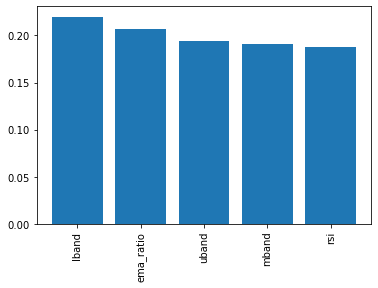

In [19]:
#graphing improtance of features
importances = rfc.feature_importances_
sorted_index = np.argsort(importances)[::-1]
x_values = range(len(importances))
labels = np.array(feature_list)[sorted_index]
plt.bar(x_values, importances[sorted_index], tick_label=labels)
plt.xticks(rotation=90)
plt.show()